In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
import torch
import pathlib
from torchvision.transforms import ToTensor
from torch import nn
from torch.nn import Sequential
from torch.optim import SGD
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
import splitfolders 
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import itertools
import plotly.express as px
from torchvision import models
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_dir = "/content/drive/MyDrive/dataset"

In [ ]:
train_dir = os.path.join(output_dir, "train")
valid_dir = os.path.join(output_dir, "valid")
test_dir = os.path.join(output_dir, "test")

In [ ]:
## Train
train_Images = glob.glob(train_dir + '/*/*.jpeg')
print("Train number of images", len(train_Images))
train_Images = pd.Series(train_Images)
traindf = pd.DataFrame()
traindf['FileName'] = train_Images.map(lambda ImageName :ImageName.split("H")[-1])
traindf['ClassId'] = train_Images.map(lambda ImageName :ImageName.split("/")[-2])
print(traindf['ClassId'].value_counts())

## Val 
val_Images = glob.glob(valid_dir +'/*/*.jpeg')
print("\nValid number of images", len(val_Images))
val_Images = pd.Series(val_Images)
valdf = pd.DataFrame()
valdf['FileName'] = val_Images.map(lambda ImageName :ImageName.split("H")[-1])
valdf['ClassId'] = val_Images.map(lambda ImageName :ImageName.split("/")[-2])
print(valdf['ClassId'].value_counts())
#
##test
test_Images = glob.glob(test_dir + '/*/*.jpeg')
print("\nTest number of images", len(test_Images))
test_Images = pd.Series(test_Images)
testdf = pd.DataFrame()
testdf['FileName'] = test_Images.map(lambda ImageName :ImageName.split("H")[-1])
testdf['ClassId'] = test_Images.map(lambda ImageName :ImageName.split("/")[-2])
print(testdf['ClassId'].value_counts())

Train number of images 16945
perro       3404
araña      3152
gallina     2168
caballo     1836
vaca        1306
ardilla     1303
mariposa    1158
oveja       1008
gato         861
elefante     749
Name: ClassId, dtype: int64

Valid number of images 2417
perro       486
araña      451
gallina     309
caballo     262
vaca        186
ardilla     186
mariposa    153
oveja       149
gato        123
elefante    112
Name: ClassId, dtype: int64

Test number of images 4851
perro       973
araña      898
gallina     621
caballo     525
vaca        374
ardilla     373
mariposa    339
oveja       287
gato        243
elefante    218
Name: ClassId, dtype: int64


In [ ]:
from torchvision import transforms, datasets

# Definir transformaciones de datos
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=test_transform)

# Crear dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:

# Definir el modelo VGG preentrenado
model = models.vgg16(pretrained=True)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)  # Cambiar la capa lineal de salida para adaptarla al número de clases

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

# Mover el modelo al dispositivo (por ejemplo, GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Entrenamiento del modelo
num_epochs = 10
best_accuracy = 0.0
patience = 5
counter = 0
best_model_path = output_dir + "/best_vgg16.pt"

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Modo de entrenamiento
    running_loss = 0.0
    correct_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Propagación hacia adelante
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Retropropagación y optimización
        loss.backward()
        optimizer.step()

        # Calcular la pérdida y precisión promedio
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()

    # Calcular la pérdida y precisión promedio por epoch
    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct_predictions / len(train_dataset)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluación en el conjunto de validación
    model.eval()  # Modo de evaluación
    val_correct_predictions = 0

    with torch.no_grad():
        for val_images, val_labels in valid_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_correct_predictions += (val_predicted == val_labels).sum().item()

    val_accuracy = val_correct_predictions / len(valid_dataset)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Train Accuracy: {epoch_accuracy:.4f} - Validation Accuracy: {val_accuracy:.4f}")


    # Verificación del early stopping y guardado del mejor modelo
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("model saved")
    else:
        counter += 1
        
    if counter >= patience:
        print("Early stopping triggered")
        break



Epoch 1/10 - Train Loss: 0.2255 - Train Accuracy: 0.9283 - Validation Accuracy: 0.9591
model saved
Epoch 2/10 - Train Loss: 0.1001 - Train Accuracy: 0.9674 - Validation Accuracy: 0.9545
Epoch 3/10 - Train Loss: 0.0667 - Train Accuracy: 0.9793 - Validation Accuracy: 0.9614
model saved
Epoch 4/10 - Train Loss: 0.0521 - Train Accuracy: 0.9830 - Validation Accuracy: 0.9640
model saved
Epoch 5/10 - Train Loss: 0.0407 - Train Accuracy: 0.9871 - Validation Accuracy: 0.9625
Epoch 6/10 - Train Loss: 0.0307 - Train Accuracy: 0.9907 - Validation Accuracy: 0.9682
model saved
Epoch 7/10 - Train Loss: 0.0247 - Train Accuracy: 0.9925 - Validation Accuracy: 0.9625
Epoch 8/10 - Train Loss: 0.0218 - Train Accuracy: 0.9930 - Validation Accuracy: 0.9591
Epoch 9/10 - Train Loss: 0.0154 - Train Accuracy: 0.9950 - Validation Accuracy: 0.9621
Epoch 10/10 - Train Loss: 0.0166 - Train Accuracy: 0.9944 - Validation Accuracy: 0.9587


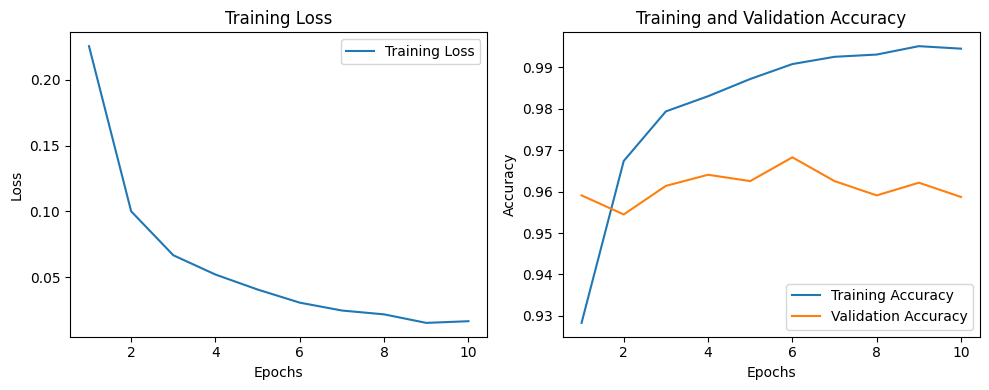

In [ ]:
# Graficar las curvas de pérdida y precisión
epochs = range(1, num_epochs+1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()  # Modo de evaluación
test_correct_predictions = 0
imglabels  = []
imgpredict = []
i=0
with torch.no_grad():
  for test_images, test_labels in test_loader:
    i+=1
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)

    test_outputs = model(test_images)
    _, test_predicted = torch.max(test_outputs.data, 1)
    imglabels.append(test_labels)
    imgpredict.append(test_predicted)
    test_correct_predictions += (test_predicted == test_labels).sum().item()

    test_accuracy = test_correct_predictions / len(test_dataset)

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9625


In [ ]:
flat_labels = []
for tensor in imglabels:
    for item in tensor.flatten():
        flat_labels.append(item.item())

flat_preds = []
for tensor in imgpredict:
    for item in tensor.flatten():
        flat_preds.append(item.item())

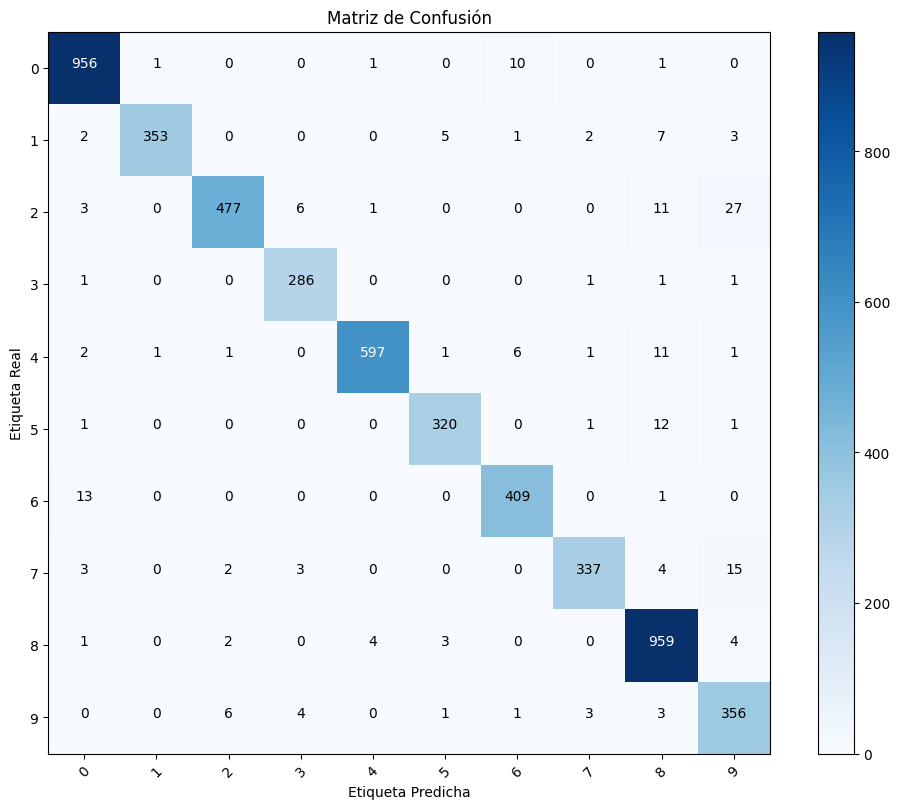

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Convertir las listas planas en arrays de NumPy
labels_array = np.array(flat_labels)
preds_array = np.array(flat_preds)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(labels_array, preds_array)

# Obtener las etiquetas únicas
unique_labels = np.unique(labels_array)

# Crear la figura de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
tick_marks = np.arange(len(unique_labels))
plt.xticks(tick_marks, unique_labels, rotation=45)
plt.yticks(tick_marks, unique_labels)

# Rellenar la matriz de confusión con los valores
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()


In [ ]:
# Cargar el mejor modelo guardado
model = models.vgg16(pretrained=True)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)
model.load_state_dict(torch.load(best_model_path))#best_model_path = output_dir + "/best_vgg16.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


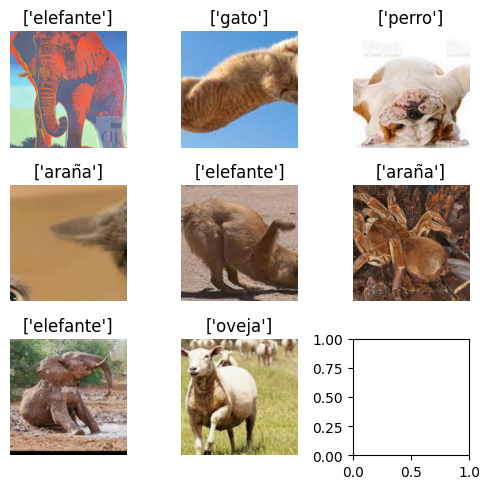

In [ ]:
import os
from PIL import Image
import torch.nn.functional as F

image_folder = "/content/drive/MyDrive/dataset/imegenes de prueba"

# Obtener la lista de archivos en la carpeta de imágenes
image_files = os.listdir(image_folder)


fig, axs = plt.subplots(3, 3, figsize=(5, 5))
# Realizar la predicción para cada imagen
for i, file in enumerate(image_files):
    # Ruta completa de la imagen
    image_path = os.path.join(image_folder, file)

    # Cargar y preparar la imagen de entrada
    image = Image.open(image_path)
    image = test_transform(image)
    image = image.unsqueeze(0)  # Añadir una dimensión adicional para el batch
    image = image.to(device)

    # Realizar la predicción
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)

    # Obtener las clases predichas
    _, predicted_indices = torch.max(probabilities, 1)
    predicted_classes = [train_dataset.classes[index] for index in predicted_indices]

    image = image.cpu()
    row = i // 3
    col = i % 3
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image.squeeze().permute(1, 2, 0).numpy()
    image = image * std + mean
    image = np.clip(image, 0, 1)
    image = Image.fromarray((image * 255).astype(np.uint8))
    axs[row, col].imshow(image)
    axs[row, col].set_title(predicted_classes)
    axs[row, col].axis('off')

    #print("Imagen:", file)
    #print("Predicción:", predicted_classes[0])
    #print()  # Espacio en blanco para separar las predicciones de cada imagen

plt.tight_layout()
plt.show()